Qui mettiamo gli import necessari per gli scripts

In [53]:
import pandas as pd
import seaborn as sns
import plotly
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from src.Vectorizer.NLTKVectorizer import NLTKVectorizer
from sklearn.linear_model import LogisticRegression  # Logistic Regression
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes
from sklearn.svm import LinearSVC  # SVM
from sklearn.ensemble import RandomForestClassifier  # Random Forest
from sklearn.pipeline import Pipeline
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\giaco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Dichiariamo le variabili che contengono i dati per il training e il testing

In [84]:
dfTrain = pd.read_csv('../Dataset/Processed/csv/train.csv')
dfTest = pd.read_csv('../Dataset/Processed/csv/test.csv')

#dichiarimo le variabili x e y per il train e il test

X_train = dfTrain['question_title']
y_train = dfTrain['topic']
X_test = dfTest['question_title']
y_test = dfTest['topic']

# Creiamo qualche grafico dal dataset

## Mettiamo qui qualche funzione che serve solo al funzionamento e al plot dei grafici

Questa funzione viene utilizata per creare una palette di n colori di palette_name colori.

In [55]:
def get_n_color_palette(palette_name, n_colors, as_hex=False):
    palette = sns.color_palette(palette=palette_name, n_colors=n_colors)
    if as_hex:
        palette = palette.as_hex()
    palette.reverse()
    return palette

Questa funzione è utilizzata per esportare l' HTML di plotly fig_obj, e salvarlo in: assets/file_name.html.
La funzione genera il report di classificazione per le previsioni del modello

In [56]:
def save_fig_as_div(fig_obj, file_name):
    with open(f"{file_name}", "w") as fig_file:
        fig_div_string = plotly.offline.plot(
            figure_or_data=fig_obj, output_type="div", include_plotlyjs="cdn"
        )
        fig_file.write(fig_div_string)

Questa funzione genera una confusion map per le previsioni del modello

In [57]:
def get_confusion_matrix(y_true, y_pred, labels):

    # calcola la confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)


    sum = 0
    diag = 0

    for i in range(len(conf_matrix)):
        for j in range(len(conf_matrix[i])):
            sum += conf_matrix[i][j]
            if i == j:
                diag += conf_matrix[i][j]



    print(f"Diagonale: {diag}, Totale: {sum}")
    print(f"Accuratezza: {(diag/sum)*100}%")



    conf_matrix = np.flipud(conf_matrix)

    # crea una heatmap annotata della matrice di confusione
    fig = ff.create_annotated_heatmap(
        conf_matrix, x=labels.tolist(), y=labels.tolist()[::-1]
    )
    fig.update_layout(
        autosize=False,
        width=800,
        height=800,
        title_text="<i><b>Confusion matrix</b></i>",
        xaxis_title="Predicted category",
        yaxis_title="Real category",
        plot_bgcolor="rgba(0, 0, 0, 0)",
        paper_bgcolor="rgba(0, 0, 0, 0)",
        font={
            "family": "Courier New, monospace",
            "size": 14,
            # 'color': "#eaeaea"
        },
    )
    fig.update_xaxes(tickangle=-45)
    fig["data"][0]["showscale"] = True

    return fig

Funzione per il classification report

In [58]:
def get_classification_report(y_true, y_pred, target_names):

    # calcola il report di classificazione e lo converte in un DataFrame

    clf_report = classification_report(
        y_true=y_true, y_pred=y_pred, target_names=target_names, output_dict=True
    )
    clf_report_df = pd.DataFrame(data=clf_report)
    clf_report_df = clf_report_df.T
    clf_report_df.drop(columns=["support"], inplace=True)

    measures = clf_report_df.columns.tolist()
    classes = clf_report_df.index.tolist()

    # crea un heatmap annotato di plotly e aggiorna lo stile

    fig = ff.create_annotated_heatmap(clf_report_df.values, x=measures, y=classes)
    fig.update_layout(
        autosize=False,
        width=800,
        height=800,
        title_text="<i><b>Classification report</b></i>",
        xaxis_title="Measures",
        yaxis_title="Class",
        plot_bgcolor="rgba(0, 0, 0, 0)",
        paper_bgcolor="rgba(0, 0, 0, 0)",
        font={
            "family": "Courier New, monospace",
            "size": 14,
            # 'color': "#eaeaea"
        },
    )
    fig.update_xaxes(tickangle=-45)
    fig["data"][0]["showscale"] = True

    return fig

Calcola per ogni topic nel dataset il numero di domande per topic

In [59]:
categories_statistics_df = (
    dfTrain.groupby(by="topic")["id"]
    .agg(
        [
            ("count", lambda x: x.size),
        ]
    )
    .reset_index()
    .sort_values(by="count", ascending=False)
)

Calcola per ogni topic nel dataset la lunghezza media delle domande per topic

In [60]:
categories_statistics_df_questions = (
    dfTrain.groupby(by="topic")["question_content"]
    .agg(
        [
            ("mean", lambda x: x.str.len().mean()),
            ("max", lambda x: x.str.len().max()),
            ("min", lambda x: x.str.len().min()),
        ]
    )
    .reset_index()
)

## Qui abbiamo le funzioni che generano i grafici sul dataset

#### Numero domande per topic:

Usiamo un grafico a torta per mostrare le percentuali di domande per ogni topic

In [61]:
blue_palette = get_n_color_palette("Blues", 20, True)

fig = px.pie(
    data_frame=categories_statistics_df,
    names="topic",
    values="count",
    color_discrete_sequence=blue_palette,
    title="Percentuale di domande per topic",
    width=800,
    height=500,
)

fig.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
        "font": {
            "family": "Courier New, monospace",
            "size": 14,
            # 'color': "#eaeaea"
        },
    }
)

fig.show()

#### Lunghezza media delle domande per topic:

Usa un diagramma a barre per mostrare la lunghezza media delle domande per ogni topic:

In [62]:
chart_labels = {"mean": "Lunghezza delle domande", "Topic": "Topic type"}

fig = px.bar(
    data_frame=categories_statistics_df_questions.sort_values(by="mean"),
    x="topic",
    y="mean",
    color="mean",
    labels=chart_labels,
    title="Lunghezza media delle domande per topic",
    width=800,
    height=500,
)

fig.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
        "font": {
            "family": "Courier New, monospace",
            "size": 14,
            # 'color': "#eaeaea"
        },
    }
)

# rotate x-axis ticks
fig.update_xaxes(tickangle=-45)

fig.show()

#### Word Cloud

La seguente word-cloud ci aiuterà a dare uno sguardo ai dati e al suo contenuto.

Per ogni word cloud, le parole con una frequenza maggiore hanno una dimensione maggiore.

Questo ci aiuterà a capire quali sono le parole più frequenti in ogni topic.

In [ ]:
nltk.download('stopwords')

nltk.download('wordnet')

en_stop_words = list(set(stopwords.words("english")))

In [64]:
categories_text_df = dfTrain.groupby(by="topic").agg({"question_title": " ".join}).reset_index()

In [65]:
def plot_word_cloud(category_name, category_text):
    plt.subplots(figsize=(8, 8))
    wc = WordCloud(
        background_color="white", stopwords=en_stop_words, width=1000, height=600
    )
    wc.generate(category_text)
    plt.title(label=category_name)
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.show()

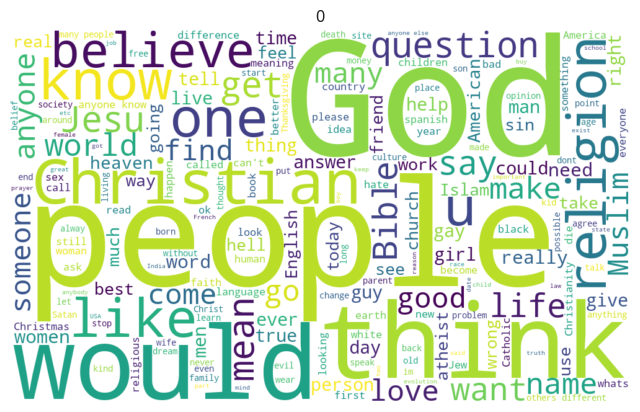

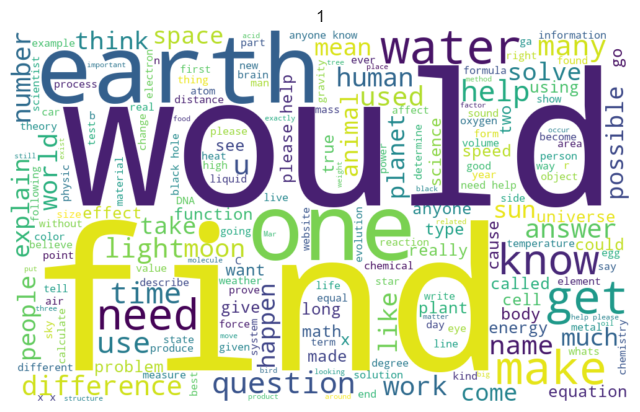

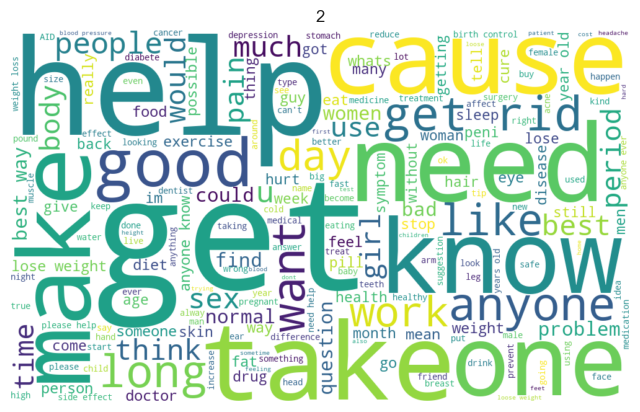

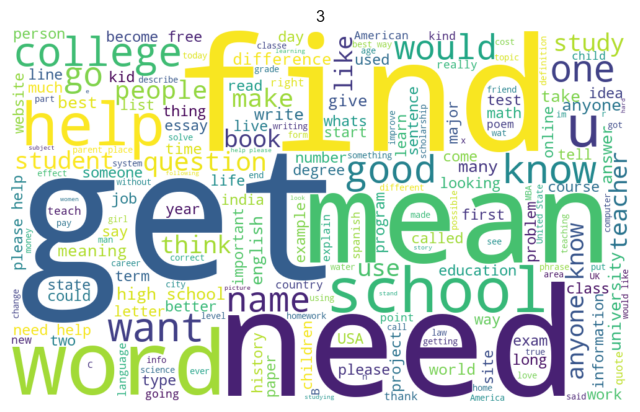

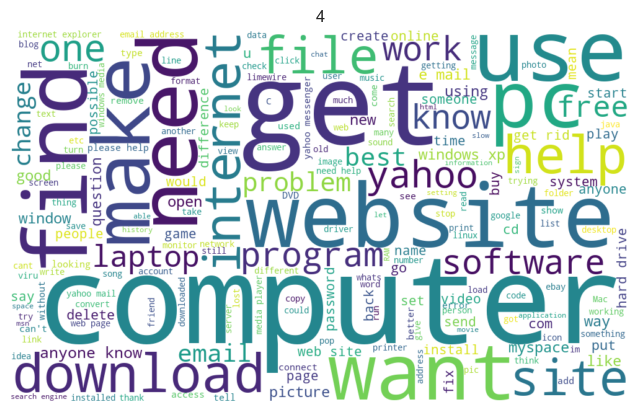

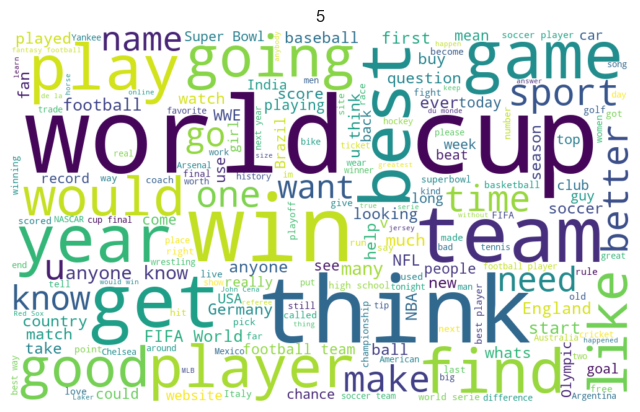

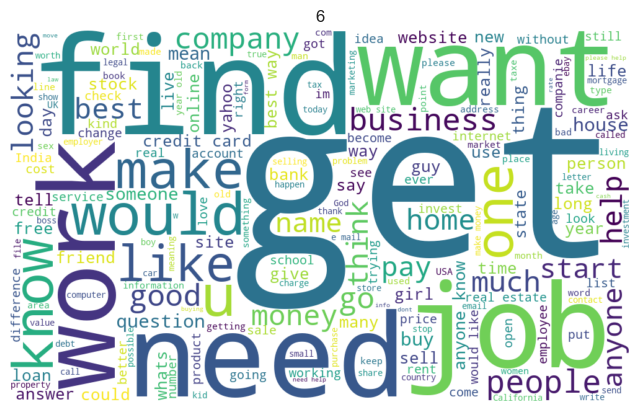

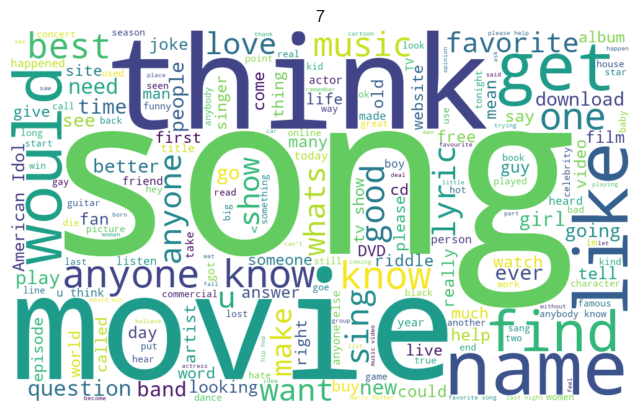

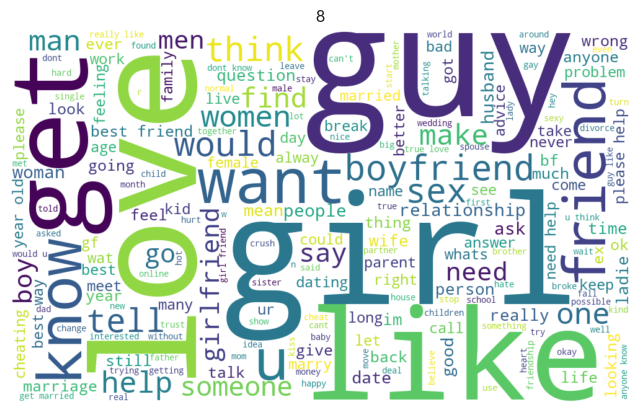

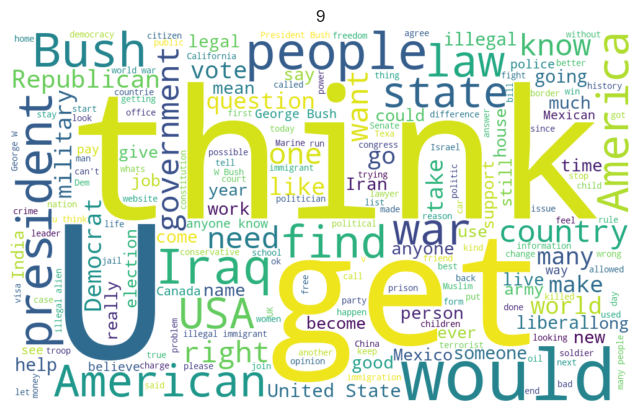

In [66]:
for idx, row in categories_text_df.iterrows():
    plot_word_cloud(row["topic"], row["question_title"])

Notiamo che le parole più comunemente usate, che però non rispecchiano il topic sono:
- think
- would
- get
- want

Quindi sono state aggiunte alla lista di stopwords.

In [67]:
# aggiungo a en_stop_words le parole dal file da noi creato
with open('stopwordsPersonali', 'r') as file:
    for line in file:
        en_stop_words.append(line.strip())

# Text Vectorization

La **text vectorization** (vettorizzazione del testo) è un processo fondamentale nel machine learning applicato al natural language processing che trasforma il testo in numeri. Serve per:


- Rappresentare il testo come vettori numerici: i modelli di machine learning lavorano solo con dati numerici, non con testo grezzo


- Catturare la semantica: trasforma le parole/frasi in rappresentazioni che mantengono relazioni semantiche (significato)


- Permettere calcoli matematici: consente di misurare similitudini tra documenti, fare clustering, classificazione, ecc.


- Ridurre la dimensionalità: converte testi variabili in vettori di dimensione fissa

Nel nostro caso andremo a utilizzare _NLTKVectorizer_

## Utilizziamo il Vectorizer

In [112]:
vectorizer = NLTKVectorizer(
    stop_words=en_stop_words, max_df=0.5, min_df=10, max_features=10000
)

# Scelta del modello

Qui di seguito troviamo tutti i modelli che possiamo prendere in considerazione

In [113]:
# Logistic Regression classifier
lr_clf = LogisticRegression(C=1.0, solver="newton-cg", multi_class="multinomial", n_jobs=1, verbose=2)

# Naive Bayes classifier
nb_clf = MultinomialNB(alpha=0.01)

# SVM classifier
svm_clf = LinearSVC(C=1.0, verbose=2)

# Random Forest classifier
random_forest_clf = RandomForestClassifier(
    n_estimators=100, criterion="gini", max_depth=50, random_state=0, n_jobs=1, verbose=2)

# Creazione della pipeline

Tramite pipeline scegliamo il modello più adeguato, nel nostro caso la **linearSVC**

In [114]:
pipeline = Pipeline([("vect", vectorizer), ("clf", lr_clf)])  #logistic regression
#pipeline = Pipeline([("vect", vectorizer), ("clf", svm_clf)]) #LinearSVC
#pipeline = Pipeline([("vect", vectorizer), ("clf", random_forest_clf)])

Continuiamo la pipeline facendo il fit, per allenare il modello

In [115]:
%%time
pipeline.fit(X_train, y_train)

C:\Users\giaco\Documents\GIACOMO\Github\Linux-day-2025\.venv\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.004434892487938168 <= 0.0001 False
  Inner CG solver iteration 4 stopped with
    sum(|residuals|) <= tol: 0.6123475782218308 <= 0.7621529760960769
  Line Search
    eps=16 * finfo.eps=3.552713678800501e-15
    try line search wolfe1
    wolfe1 line search was successful
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.01680572881140783 <= 0.0001 False
  Inner CG solver iteration 14 stopped with
    sum(|residuals|) <= tol: 0.3114184706913269 <= 0.31895936124270985
  Line Search
    eps=16 * finfo.eps=3.552713678800501e-15
    try line search wolfe1
    wolfe1 line search was successful
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.005672859016444433 <= 0.0001 False
  Inner CG solver iteration 14 stopped with
    sum(|residuals|) <= tol: 0.20732504209835223 <= 0.20959516149031387
  Line Search
    eps=16 * finfo.eps=3.552713678800501e-15
    try line search wolfe1
    wolfe1 lin

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


,steps,"[('vect', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [116]:
%%time
y_pred = pipeline.predict(X_test)


CPU times: total: 4.19 s
Wall time: 6.45 s


# Classification report:

In [117]:
target_names = [0, 1, 2, 3 ,4 ,5 ,6, 7, 8 ,9]
target_names=list(map(str,target_names))
classes = target_names
fig = get_classification_report(
    y_true=y_test, y_pred=y_pred, target_names=classes
)
fig.show()

# Confusion matrix con calcolo diagonale e totale:

In [118]:
fig = get_confusion_matrix(y_true=y_test, y_pred=y_pred, labels=pipeline.classes_)
fig.show()

Diagonale: 37844, Totale: 60000
Accuratezza: 63.07333333333334%


# Dump del modello

In [119]:
from joblib import dump, load

dump(pipeline, '../dump/model_lr.joblib')
pipeline = load('../dump/model_lr.joblib')

# Carichiamo il modello e utilizziamolo per fare delle previsioni

In [120]:
text = input('Inserisci la domanda:')

predictProba = pipeline.predict_proba([text])
print(predictProba)

array = ["Society & culture", "Science & Mathematics", "Health", "Education & Reference", "Computers & Internet", "Sports", "Business & Finance", "Entertainment & Music", "Family & Relationships", "Politics & Government"]
stat = predictProba[0][pipeline.predict([text])[0]] * 100

print("\"" + text + "\"" + "\n" " is about: " + "\"" + array[pipeline.predict([text])[0]]+ "\"" +"\n"+" con una probabilità del " +"%.3f" %stat + "%" "\n")

for i in range(10):
    print("\t\t\t"+ array[i] + " : " + "%.3f" % (predictProba[0][i] * 100) + "%")

[[0.02674064 0.01739073 0.01356161 0.01844101 0.76825773 0.013786
  0.0326479  0.05452031 0.02927982 0.02537425]]
"What about gaming?"
 is about: "Computers & Internet"
 con una probabilità del 76.826%

			Society & culture : 2.674%
			Science & Mathematics : 1.739%
			Health : 1.356%
			Education & Reference : 1.844%
			Computers & Internet : 76.826%
			Sports : 1.379%
			Business & Finance : 3.265%
			Entertainment & Music : 5.452%
			Family & Relationships : 2.928%
			Politics & Government : 2.537%
